In [1]:
import torchattacks
from models.mnist_classifier.lenet import LeNet5, LeNet1
import torch
import torchvision
from torchvision.datasets.mnist import MNIST
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchcam.methods import GradCAMpp, GradCAM
import torchvision.models as models
import numpy as np
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
import os
import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# lenet1的输入是28*28，lenet5的输入是32*32
net = torchvision.models.resnet18(pretrained=False)
# net = LeNet1()
# net_dir = 'autodl-tmp/save_model/fashion/Lenet1/re_lenet_epoch=18_test_acc=0.809.pth'
net_dir = 'autodl-tmp/save_model/fashion/resnet18/resnet_epoch=4_test_acc=0.901.pth'
net.load_state_dict(torch.load(net_dir))
net.eval()
net = net.to(device)

In [16]:
# 将数据集转换为PyTorch张量，并将像素值标准化为范围在0到1之间
# mean = [0.5]
# std = [0.5]
mean = [0.5,0.5,0.5]
std = [0.5,0.5,0.5]
# 如果要运行lenet模型，把下面的lambda这行删掉
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
    transforms.Normalize(mean, std)])
data_root = './autodl-tmp/fashion-mnist'
trainset = FashionMNIST(root=data_root, train=True,
                 download=False,transform=transform)
testset = FashionMNIST(root=data_root, train=False,
                download=False,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=8)

In [17]:
(ims, labs) = next(iter(testloader))	# images：Tensor(64,1,28,28)、labels：Tensor(64,)
ims = ims.to(device)
labs = labs.to(device)

In [18]:
labs = labs.cpu().numpy()

In [19]:
# 计算预训练模型acc
preds = net(ims).cpu().detach().numpy()
class_preds = np.argmax(preds, axis=1)
print(class_preds)
print('test acc', np.sum(class_preds == labs) / 256)

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 6 8 0 2 5 7 5 1 4 6 6 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 6 7 4 7 2 1 2 6 6 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 4 4 7 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2 3 6 7 2 7 8 5 9 9 4 2
 5 7 0 5 2 8 4 7 8 0 0 9 9 3 0 8 4 1 5 4 1 9 1 8 4 2 1 2 5 1 6 0 0 1 6 1 3
 2 2 2 4 1 4 5 6 4 7 9 3 7 2 3 9 0 9 4 7 4 2 6 5 2 1 2 1 3 0 9 1 0 9 3 6 7
 9 9 4 4 7 1 2 1 6 3 2 8 3 6 1 1 0 2 9 2 4 0 7 9 8 4 1 8 4 1 3 1 6 7 2 8 5
 2 0 7 7 6 2 7 6 7 8 9 2 9 0 5 1 4 4 5 6 9 2 2 8 6 4 6 2 9 7 6 5 5 2]
test acc 0.921875


In [20]:
loaders_scratch = {'train': trainloader, 'test': testloader}
X, Y = iter(loaders_scratch['test']).next()
X, Y = X.to(device), Y.to(device)
Y_logits = net(X)
Y_probs = F.softmax(Y_logits, dim=-1)
Y_preds = Y_probs.argmax(axis=-1)

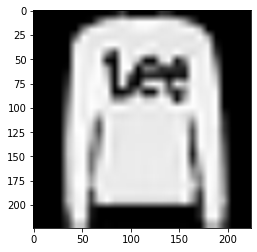

In [21]:
# 你下次打开肯定忘了：这里X是图像，Y是对应的标签，一共10000张。X[1:2][0]是(1,32,32)的一张图
orig_image = X[1:2][0].cpu().numpy().transpose(1, 2, 0)  # 交换通道
std = [0.5, 0.5, 0.5]
mean = [0.5, 0.5, 0.5]
orig_image = orig_image * std + mean
plt.imshow(orig_image)
plt.show()

In [22]:
img_tensor = torch.unsqueeze(ims[1], dim=0).float()
img_variable = Variable(img_tensor, requires_grad=True)
output = net.forward(img_variable)
label_idx = int(torch.max(output.data, 1)[1][0])   #get an index(class number) of a largest element
print(label_idx)

2


In [23]:
mnist_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fashion_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
x_pred = fashion_labels[label_idx]
print(x_pred)

Pullover


In [24]:
# PGD
y_true = 2   #change this if you change input image
target = Variable(torch.LongTensor([y_true]), requires_grad=False)
print(target)

tensor([2])


In [25]:
# 将图像tensor归一化到0-1中
img_tensor = img_tensor.cpu()
min_val = torch.min(img_tensor)
max_val = torch.max(img_tensor)
img_tensor_normalized = (img_tensor - min_val) / (max_val - min_val)

In [26]:
eps = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
attack = torchattacks.PGD(net, eps=eps[4])
# perturbed_data = (torchattacks.BIM(model, epsilon, 0.2, steps=4))
perturbed_data = attack(img_tensor_normalized, target)

In [27]:
perturbed_data = perturbed_data.cpu()
noise = perturbed_data - img_tensor_normalized

In [28]:
# 去标准化
perturbed_data = perturbed_data * (max_val - min_val) + min_val

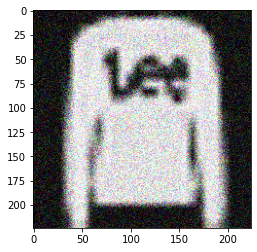

In [29]:
adv_image = perturbed_data[0].cpu().numpy().transpose(1, 2, 0)  # 交换通道
std = [0.5, 0.5, 0.5]
mean = [0.5, 0.5, 0.5]
adv_image = adv_image * std + mean
plt.imshow(adv_image)
plt.show()

In [30]:
noise = noise * (max_val - min_val) + min_val

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


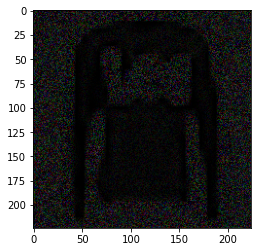

In [31]:
noise_map = noise[0].cpu().numpy().transpose(1, 2, 0)  # 交换通道
std = [0.5, 0.5, 0.5]
mean = [0.5, 0.5, 0.5]
noise_map = noise_map * std + mean
plt.imshow(noise_map)
plt.show()

In [32]:
# 计算图像质量指标
import pytorch_ssim

def psnr(img1, img2):
    img1 = img1.cpu()
    img2 = img2.cpu()
    mse = F.mse_loss(img1.float(), img2.float())
    psnr = 10 * torch.log10(1/mse)
    return psnr

def mse(img1, img2):
    img1 = img1.cpu()
    img2 = img2.cpu()
    mse = F.mse_loss(img1.float(), img2.float())
    return mse

def ssim(img1, img2):
    img1 = img1.cpu()
    img2 = img2.cpu()
    ssim = pytorch_ssim.ssim(img1.float(), img2.float())
    return ssim

In [33]:
mse(perturbed_data, X[1:2]).item()

0.07771908491849899

In [34]:
ssim(X[1:2], perturbed_data).item()

0.1959509253501892

In [35]:
psnr(perturbed_data, X[1:2]).item()

11.094722747802734

In [ ]:
perturbed_data.shape

In [ ]:
X[1:2].shape